## Classification of PheWAS Cohorts
#### Alexander Eyre (2023)

___
### Define Functions

In [44]:
def comparehist(data1, data2, data3, idx_list, ax_idx):
    bins_list     = [1,2,3,4,5,6]
    i             = 0
    nrow          = 0
    ncol          = 0

    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data1.columns):
                break
            
            ax_idx[nrow, ncol].hist(list(data1.iloc[:,i]),
                                    bins    = bins_list,
                                    range   = (1,6),
                                    alpha   = 0.5,
                                    color   = "red",
                                    density = True)

            ax_idx[nrow, ncol].hist(list(data2.iloc[:,i]),
                                    bins    = bins_list,
                                    range   = (1,6),
                                    alpha   = 0.5,
                                    color   = "yellow",
                                    density = True)
            
            ax_idx[nrow, ncol].hist(list(data3.iloc[:,i]),
                                    bins    = bins_list,
                                    range   = (1,6),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            
            ax_idx[nrow, ncol].set_title(idx_list[i])
            matplotlib.pyplot.xticks(ticks  = [1.5, 2.5, 3.5, 4.5, 5.5],
                                     labels = ["1", "2", "3", "4", "5"])
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1  

____
### Load Packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import compress
from tabulate import tabulate
%matplotlib inline

# Data Preparation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Analyses
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from umap import UMAP

____
### Data Importation & Cleanup

In [2]:
AUS_CBARQ           = pd.read_csv("AUS_PostCBARQ.txt").iloc[:,1:]
AUS_Factors         = pd.read_csv("AUS_CBARQFactors.csv").iloc[:,1:]
UK_CBARQ            = pd.read_csv("UK_PostCBARQ.txt").iloc[:,1:]
UK_Factors          = pd.read_csv("UK_CBARQFactors.csv").iloc[:,1:]
SE_CBARQ            = pd.read_csv("SE_PostCBARQ.txt").iloc[:,1:]
SE_Factors          = pd.read_csv("SE_CBARQFactors.csv").iloc[:,1:]

In [3]:
All_CBARQ           = pd.concat([AUS_CBARQ, UK_CBARQ, SE_CBARQ])
All_Factors         = pd.concat([AUS_Factors, UK_Factors, SE_Factors])

In [4]:
All_Color           = list(pd.concat([pd.DataFrame(np.repeat("AUS", repeats = len(AUS_CBARQ))),
                                      pd.DataFrame(np.repeat("UK", repeats = len(UK_CBARQ))),
                                      pd.DataFrame(np.repeat("SE", repeats = len(SE_CBARQ)))])[0])
AUS_Color           = list(np.repeat("AUS", repeats = len(AUS_CBARQ)))
UK_Color            = list(np.repeat("UK", repeats = len(UK_CBARQ)))
SE_Color            = list(np.repeat("SE", repeats = len(SE_CBARQ)))

In [5]:
imp                 = IterativeImputer(max_iter = 500, random_state = 101)
imp.fit(AUS_CBARQ)
curr_data           = imp.transform(AUS_CBARQ)
AUS_CBARQ_imp       = pd.DataFrame(curr_data, columns = AUS_CBARQ.columns)

In [6]:
imp                 = IterativeImputer(max_iter = 500, random_state = 101)
imp.fit(UK_CBARQ)
curr_data           = imp.transform(UK_CBARQ)
UK_CBARQ_imp        = pd.DataFrame(curr_data, columns = UK_CBARQ.columns)

In [7]:
imp                 = IterativeImputer(max_iter = 500, random_state = 101)
imp.fit(SE_CBARQ)
curr_data           = imp.transform(SE_CBARQ)
SE_CBARQ_imp        = pd.DataFrame(curr_data, columns = SE_CBARQ.columns)

In [8]:
All_CBARQ_imp       = pd.concat([AUS_CBARQ_imp, UK_CBARQ_imp, SE_CBARQ_imp])[SE_CBARQ_imp.columns]

____
### Data Visualization
Red    = Australian

Yellow = United Kingdom

Blue   = Seeing Eye

<bound method Figure.tight_layout of <Figure size 1500x6400 with 100 Axes>>

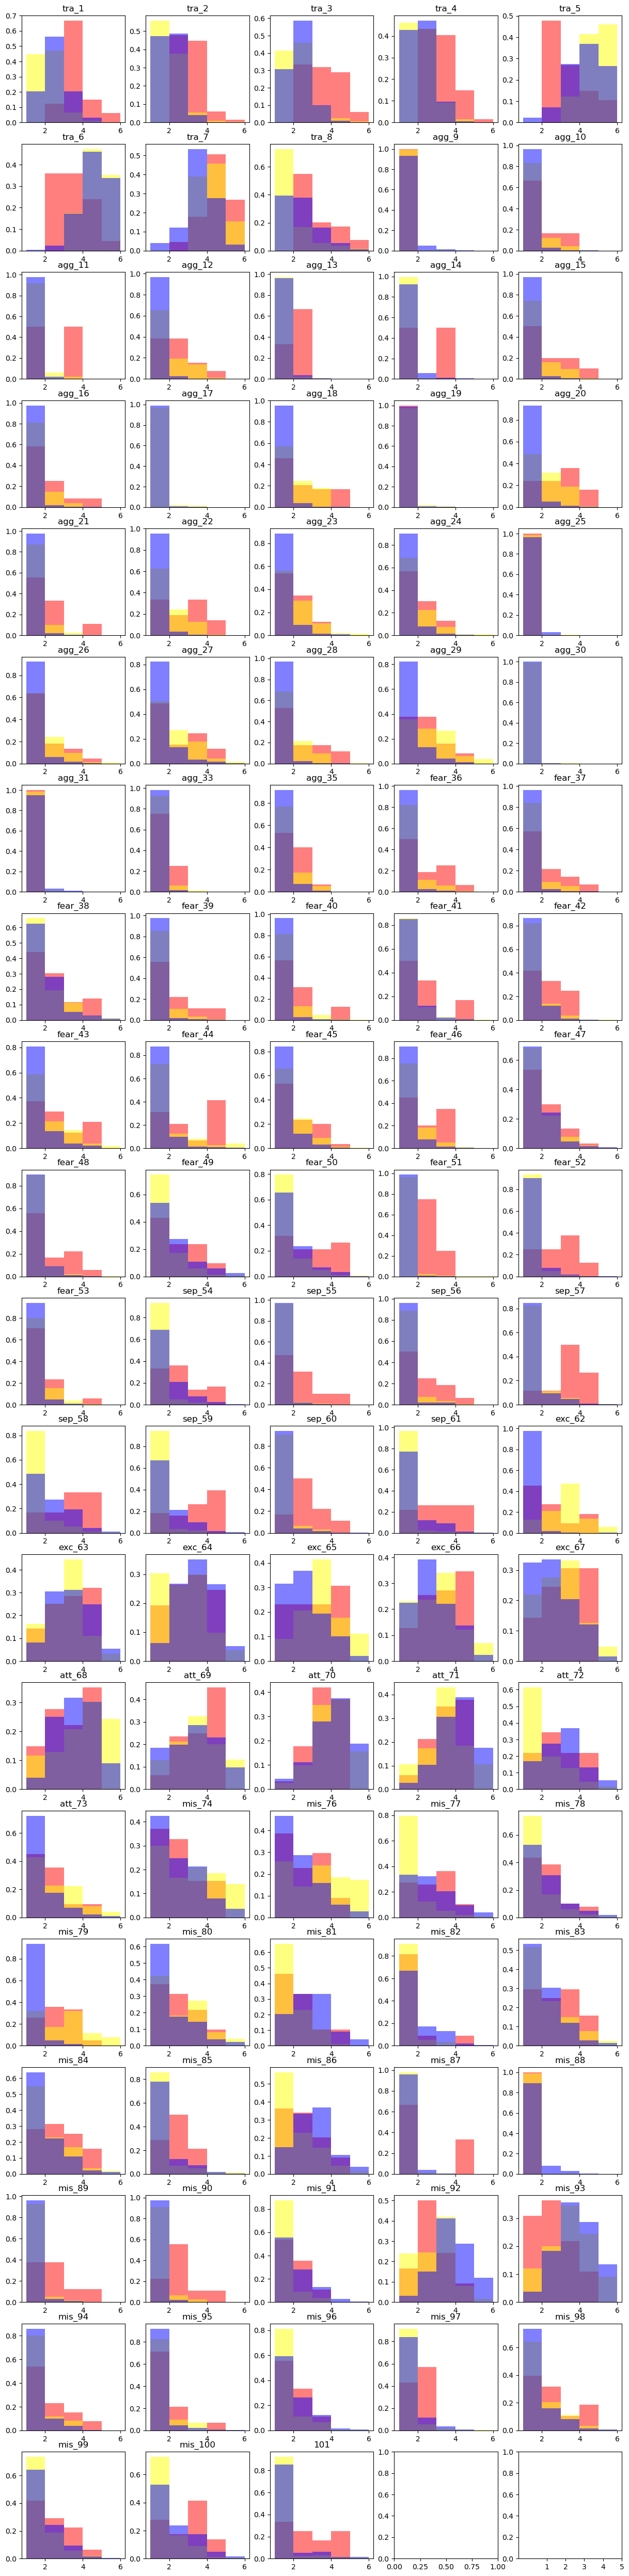

In [45]:
# Relative Histogram Plots of CBARQ Questions 
ax_idx = []
for i in np.arange(0,len(All_CBARQ_imp),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(All_CBARQ_imp.columns)/5)),
                             ncols = 5,
                             figsize = (3*5, 3.2*int(np.ceil(len(All_CBARQ_imp.columns)/5))))

comparehist(AUS_CBARQ_imp[SE_CBARQ_imp.columns], 
            UK_CBARQ_imp[SE_CBARQ_imp.columns], 
            SE_CBARQ_imp[SE_CBARQ_imp.columns], 
            SE_CBARQ_imp.columns, 
            ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x2400 with 40 Axes>>

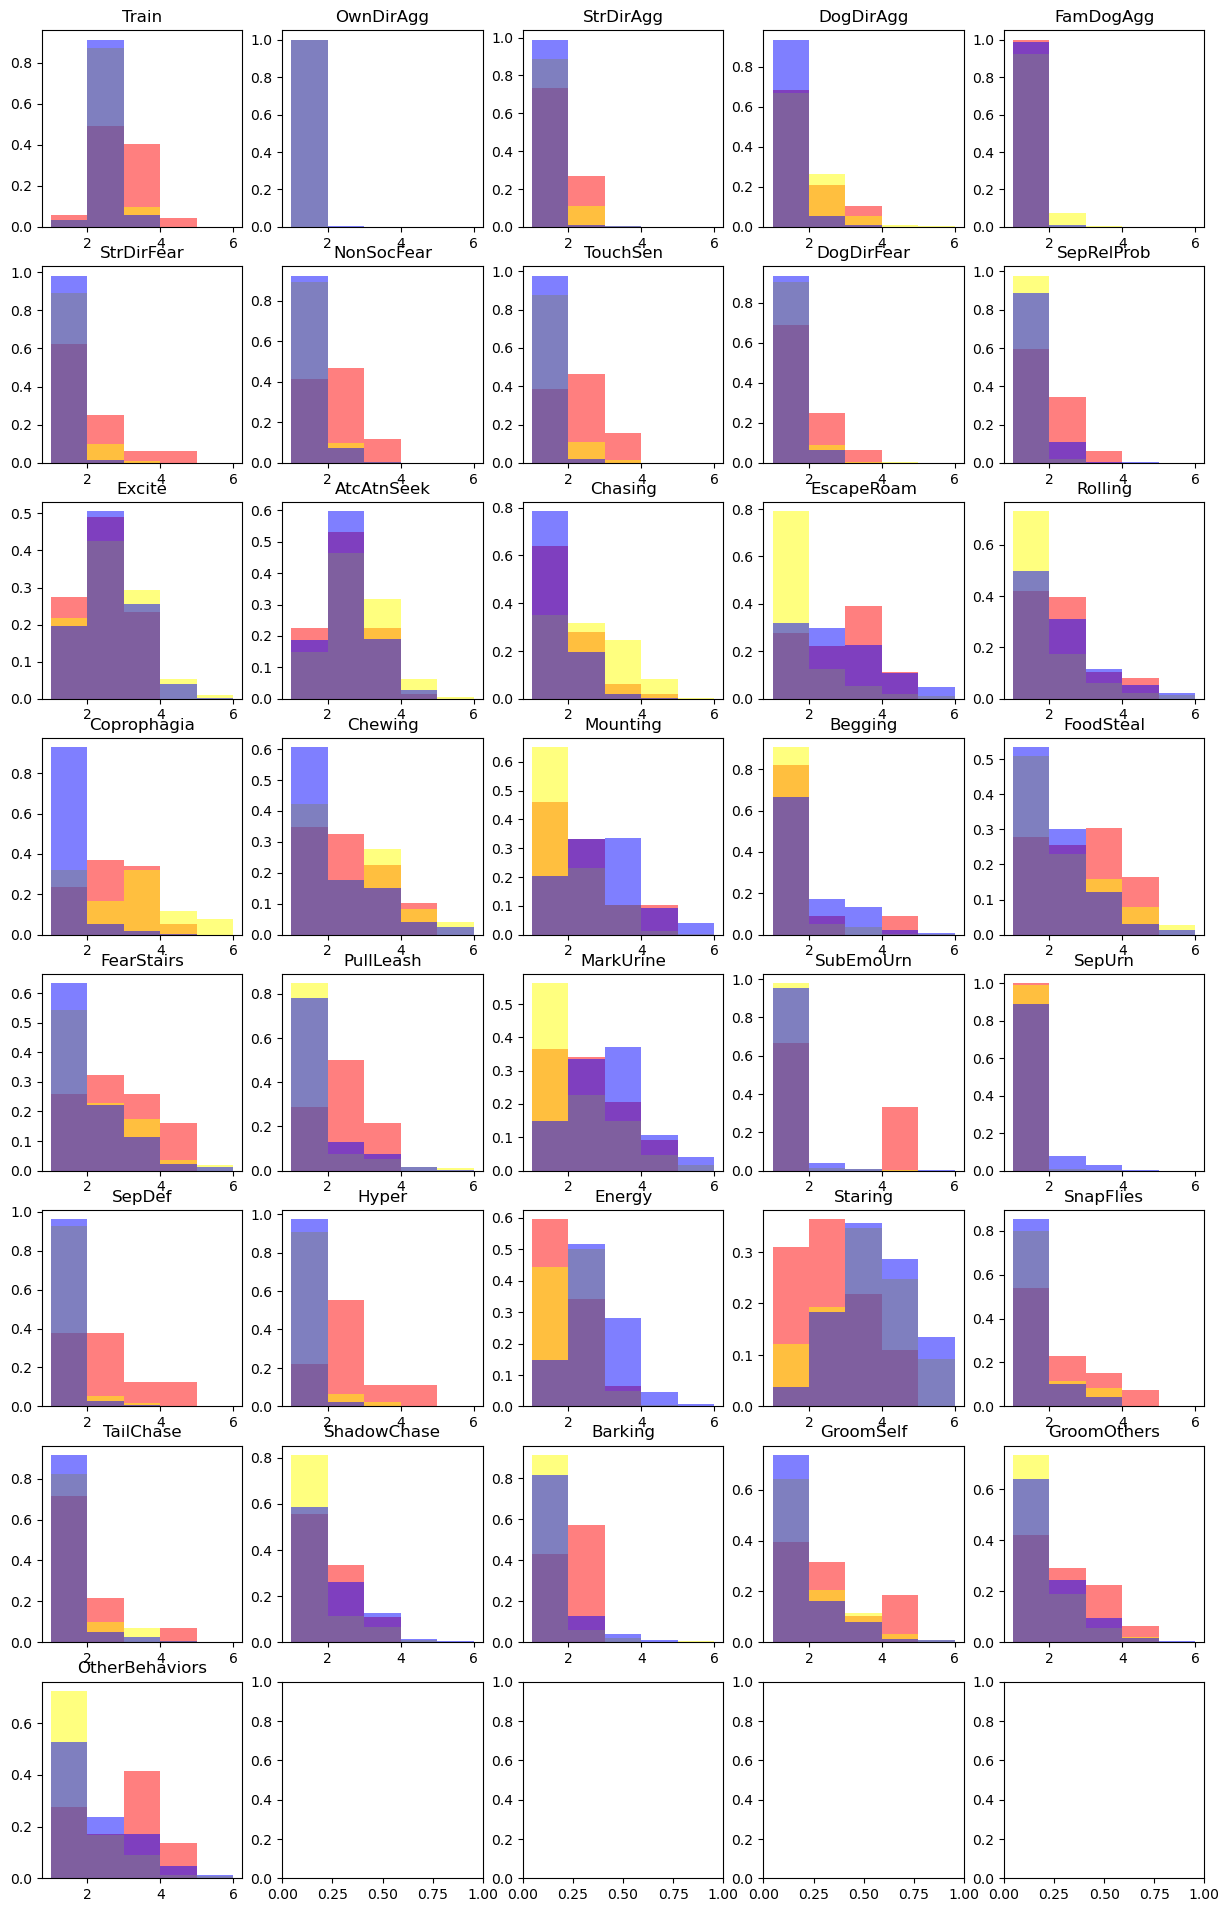

In [31]:
# Relative Histogram Plots of CBARQ Questions 
ax_idx = []
for i in np.arange(0,len(All_Factors),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(All_Factors.columns)/5)),
                             ncols = 5,
                             figsize = (3*5, 3*int(np.ceil(len(All_Factors.columns)/5))))

comparehist(AUS_Factors, 
            UK_Factors, 
            SE_Factors, 
            SE_Factors.columns, 
            ax_idx)
fig.tight_layout

____
### Select Dataset

In [9]:
# Select Datasets
curr_data          = All_CBARQ_imp
curr_color         = All_Color

____
### Analyses
#### Principal Component Analysis

In [10]:
# Run PCA
pca                 = PCA(n_components = 10,
                          random_state = 101)
curr_pca            = pca.fit_transform(curr_data)

In [11]:
# Setup the top two components for the PCA
i   = 0
PC1 = []
PC2 = []
while i < len(curr_pca):
    PC1.append(curr_pca[i][0])
    PC2.append(curr_pca[i][1])
    i = i + 1

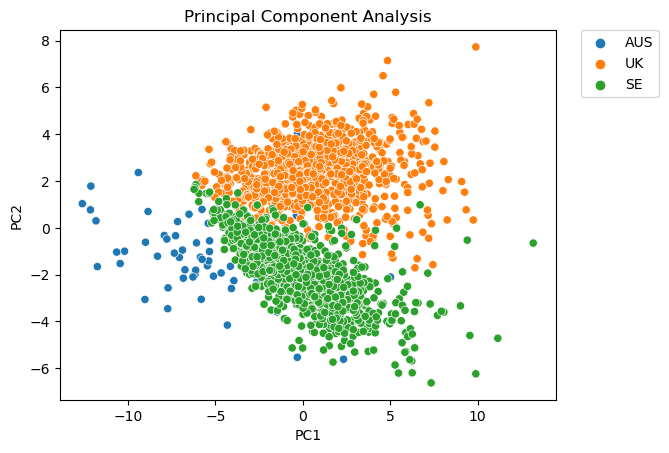

In [12]:
# Plot the top two components against eachother
sns.scatterplot(x = PC1, 
                y = PC2, 
                hue = curr_color)
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### Multidimensional Scaling (MDS)

In [13]:
# Run MDS
mds            = MDS(n_components = 2,
                     max_iter = 300,
                     eps = 1e-3,
                     random_state = 101)
curr_mds       = mds.fit_transform(curr_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [14]:
# Setup X and Y values for plot
i              = 0
mds_X          = []
mds_Y          = []
while i < len(curr_mds):
    mds_X.append(curr_mds[i][0])
    mds_Y.append(curr_mds[i][1])
    i = i + 1

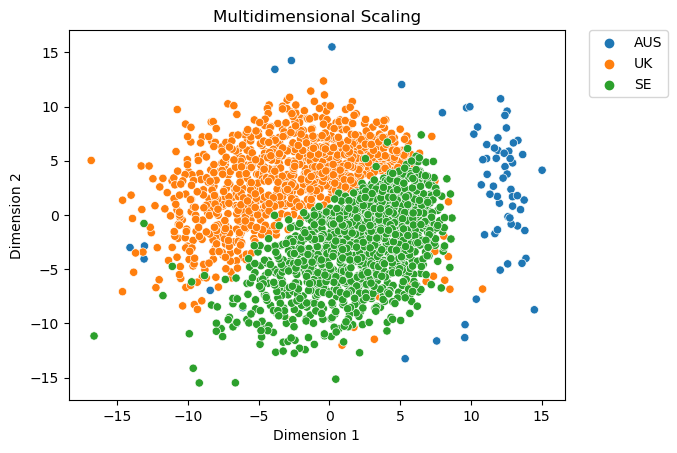

In [15]:
# Plot MDS
sns.scatterplot(x = mds_X, 
                y = mds_Y, 
                hue = curr_color)
plt.title("Multidimensional Scaling")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [16]:
tsne           = TSNE(n_components = 2,
                      perplexity = 30,
                      early_exaggeration = 12,
                      learning_rate = 200,
                      n_iter = 1000,
                      n_iter_without_progress = 300,
                      min_grad_norm = 1e-7,
                      metric = 'euclidean',
                      init = 'random',
                      random_state = 101)
curr_tsne      = tsne.fit_transform(curr_data)

In [17]:
# Setup X and Y values for plot
i              = 0
tsne_X         = []
tsne_Y         = []
while i < len(curr_tsne):
    tsne_X.append(curr_tsne[i][0])
    tsne_Y.append(curr_tsne[i][1])
    i = i + 1

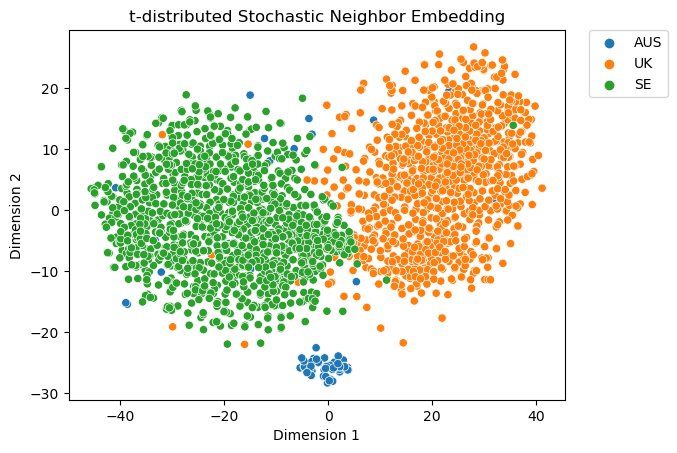

In [18]:
# Plot tSNE
sns.scatterplot(x = tsne_X, 
                y = tsne_Y, 
                hue = curr_color)
plt.title("t-distributed Stochastic Neighbor Embedding")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### Uniform Manifold Approximation and Projection (UMAP)

In [19]:
umap           = UMAP(n_components = 2,
                      init = 'random',
                      random_state = 101)
curr_umap      = umap.fit_transform(curr_data)

In [20]:
# Setup X and Y values for plot
i              = 0
umap_X         = []
umap_Y         = []
while i < len(curr_umap):
    umap_X.append(curr_umap[i][0])
    umap_Y.append(curr_umap[i][1])
    i = i + 1

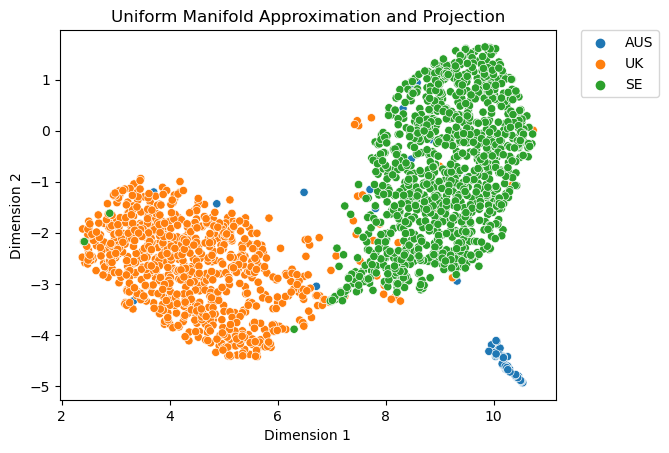

In [21]:
# Plot UMAP
sns.scatterplot(x = umap_X, 
                y = umap_Y, 
                hue = curr_color)
plt.title("Uniform Manifold Approximation and Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)